In [35]:
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pylab as plt

import tensorflow as tf

import tensorflow_hub as hub

from tensorflow.keras import layers

import numpy as np

import PIL.Image as Image

import time


In [2]:
classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2" #@param {type:"string"}

In [3]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))])


In [4]:
grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper = np.array(grace_hopper)/125.0
grace_hopper

array([[[0.2  , 0.224, 0.664],
        [0.24 , 0.256, 0.744],
        [0.264, 0.272, 0.808],
        ...,
        [0.584, 0.888, 1.488],
        [0.528, 0.832, 1.432],
        [0.448, 0.752, 1.352]],

       [[0.2  , 0.224, 0.664],
        [0.192, 0.208, 0.696],
        [0.184, 0.192, 0.712],
        ...,
        [0.624, 0.912, 1.504],
        [0.648, 0.936, 1.528],
        [0.688, 0.976, 1.568]],

       [[0.168, 0.192, 0.632],
        [0.184, 0.2  , 0.688],
        [0.232, 0.24 , 0.76 ],
        ...,
        [0.736, 1.032, 1.6  ],
        [0.648, 0.944, 1.512],
        [0.664, 0.96 , 1.528]],

       ...,

       [[1.296, 0.08 , 0.184],
        [1.32 , 0.144, 0.224],
        [1.216, 0.176, 0.192],
        ...,
        [0.072, 0.064, 0.112],
        [0.088, 0.08 , 0.128],
        [0.088, 0.08 , 0.128]],

       [[1.296, 0.112, 0.224],
        [1.216, 0.064, 0.136],
        [1.168, 0.16 , 0.168],
        ...,
        [0.112, 0.104, 0.152],
        [0.136, 0.128, 0.176],
        [0.112,

In [5]:
result = classifier.predict(grace_hopper[np.newaxis, ...])
predicted_class = np.argmax(result[0], axis=-1)


In [6]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

W0703 12:53:42.719795 16128 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


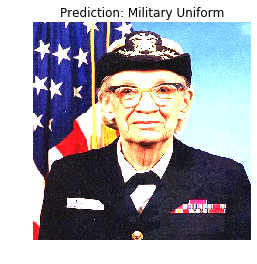

In [7]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

In [8]:
data_root = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)

In [9]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE)

Found 3670 images belonging to 5 classes.


In [10]:
for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)


In [11]:
result_batch = classifier.predict(image_batch)
result_batch.shape

(32, 1001)

In [12]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['pot', 'sulphur butterfly', 'cliff', 'daisy', 'pot', 'daisy',
       'velvet', 'vase', 'daisy', 'daisy', 'bee', 'grasshopper', 'daisy',
       'hip', 'strawberry', 'artichoke', 'vase', 'daisy', 'pot', 'daisy',
       'sea urchin', 'cabbage butterfly', 'wool', 'pot', 'lorikeet',
       'hair slide', 'feather boa', "jack-o'-lantern", 'teddy',
       'wine bottle', 'broccoli', 'quill'], dtype='<U30')

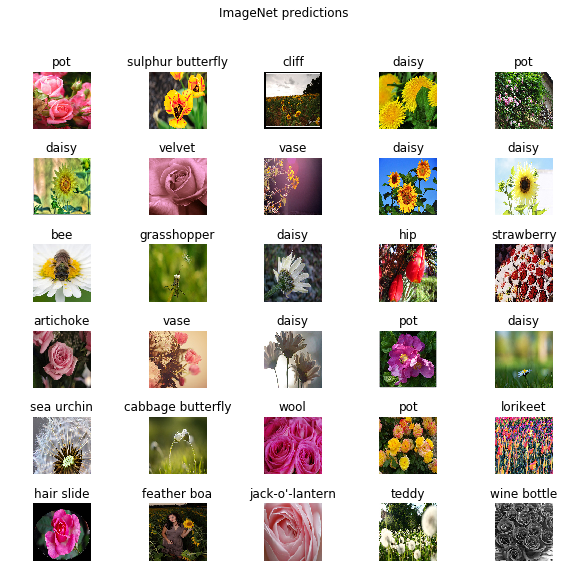

In [13]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

In [14]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2" #@param {type:"string"}


In [15]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))

In [16]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


In [17]:
feature_extractor_layer.trainable = False

In [18]:
model = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dense(image_data.num_classes, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [19]:
predictions = model(image_batch)

In [20]:
predictions.shape


TensorShape([32, 5])

In [21]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])


In [22]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

In [23]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit(image_data, epochs=2,
                    steps_per_epoch=steps_per_epoch,
                    callbacks = [batch_stats_callback])

W0703 12:53:49.305116 16128 deprecation.py:323] From C:\Users\Magenta\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/2
115/115 [==============================] - 274s 2s/step - loss: 0.8762 - acc: 0.8750
Epoch 2/2
115/115 [==============================] - 269s 2s/step - loss: 0.5130 - acc: 0.9375


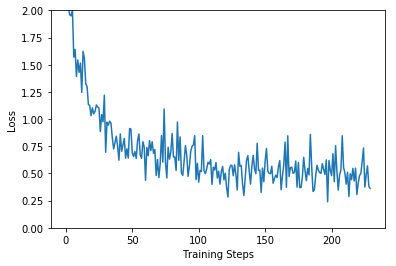

In [24]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

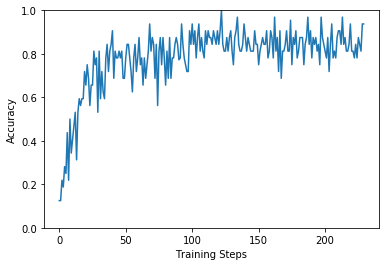

In [25]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

In [26]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

In [27]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
label_id = np.argmax(label_batch, axis=-1)


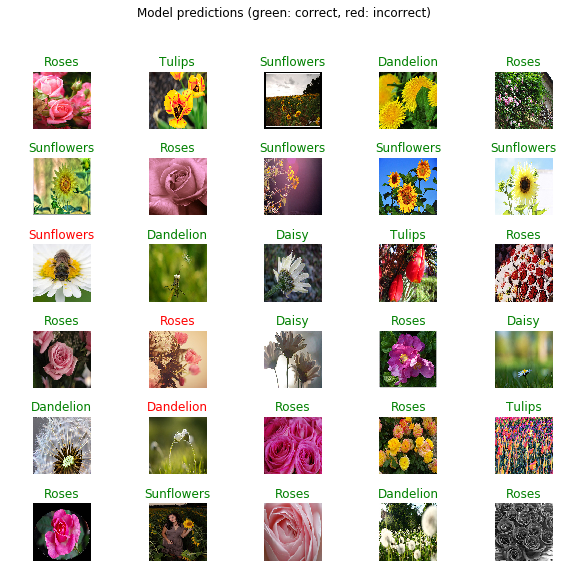

In [34]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

In [36]:
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
tf.keras.experimental.export_saved_model(model, export_path)

export_path

W0703 13:57:50.745322 16128 deprecation.py:323] From C:\Users\Magenta\Anaconda3\lib\site-packages\tensorflow\python\saved_model\signature_def_utils_impl.py:253: build_tensor_info (from tensorflow.python.saved_model.utils_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
W0703 13:57:50.746292 16128 export_utils.py:182] Export includes no default signature!
W0703 13:57:51.315799 16128 meta_graph.py:450] Issue encountered when serializing variables.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'
W0703 13:57:55.595319 16128 export_utils.py:182] Export includes no default signature!
W0703 13:57:56.006249 16128 meta_graph.py:450] Issue encountered when ser

'/tmp/saved_models/1562129866'

In [37]:
reloaded = tf.keras.experimental.load_from_saved_model(export_path, custom_objects={'KerasLayer':hub.KerasLayer})


Exception ignored in: <function _CheckpointRestoreCoordinator.__del__ at 0x000001CDB06AC400>
Traceback (most recent call last):
  File "C:\Users\Magenta\Anaconda3\lib\site-packages\tensorflow\python\training\tracking\util.py", line 244, in __del__
    .format(pretty_printer.node_names[node_id]))
  File "C:\Users\Magenta\Anaconda3\lib\site-packages\tensorflow\python\training\tracking\util.py", line 93, in node_names
    path_to_root[node_id] + (child.local_name,))
  File "C:\Users\Magenta\Anaconda3\lib\site-packages\tensorflow\python\training\tracking\object_identity.py", line 76, in __getitem__
    return self._storage[self._wrap_key(key)]
KeyError: (<tensorflow.python.training.tracking.object_identity._ObjectIdentityWrapper object at 0x000001CD8C6CBD68>,)


In [38]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

abs(reloaded_result_batch - result_batch).max()

0.0